# Analysing WaPOR data


### Example
For this exercise, we can make use of the user-defined functions we made in the previous exercise to read can write raster data.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from osgeo import gdal

def GetRasterInfo(in_fh):
    DataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)
    Type = DataSet.GetDriver().ShortName
    bandnumber=1
    Subdataset = DataSet.GetRasterBand(bandnumber)
    NDV = Subdataset.GetNoDataValue()
    xsize = DataSet.RasterXSize
    ysize = DataSet.RasterYSize
    GeoT = DataSet.GetGeoTransform()
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(DataSet.GetProjectionRef())
    driver = gdal.GetDriverByName(Type)
    return NDV,xsize,ysize,GeoT,Projection,driver

def OpenRasterAsArray(in_fh,nan_value=True,bandnumber=1,dtype='float32'):  
    SourceDataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)    
    Subdataset = SourceDataSet.GetRasterBand(bandnumber)
    NDV = Subdataset.GetNoDataValue()
    Array = Subdataset.ReadAsArray().astype(dtype)
    if nan_value:
        Array[Array == NDV] = np.nan
    return Array

def SaveArrayAsRaster(Array,out_fh,NDV,xsize,ysize,GeoT,Projection,driver,dtype='float32'):
    datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
    "int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
    "Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    DataSet = driver.Create(out_fh,xsize,ysize,1,datatypes[dtype])
    if NDV is None:
        NDV=-9999
    DataSet.GetRasterBand(1).SetNoDataValue(NDV)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection.ExportToWkt())
    DataSet.GetRasterBand(1).WriteArray(Array)
    return out_fh

def MatchProjResNDV(source_fh,target_fh,output_folder,dtype='float32',resample='near'):
    s_ndv,s_srs,s_ts,s_te=GetGdalwarpInfo(source_fh)
    t_ndv,t_srs,t_ts,t_te=GetGdalwarpInfo(target_fh) 
    output_file=os.path.join(output_folder,os.path.split(source_fh)[-1])
    string = 'gdalwarp -overwrite -s_srs {0} -t_srs {1} -te {2} -ts {3} -ot {4} -r {5} -srcnodata {6} -dstnodata {7} -of GTiff {8} {9}'.format(s_srs,t_srs,t_te,t_ts,dtype,resample,s_ndv,t_ndv,source_fh,output_file)
    proc = subprocess.Popen(string, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err = proc.communicate()
    print(out,err)
    return output_file 

## 1. Calculate the average value of ROI
### Example
Calculate average precipitation in a ROI from a raster map (mm/month)

In [3]:
import os 
import glob

LU_fh=r"E:\Exercise\Awash\LUWA\Awash2009.tif"
P_folder=r'E:\Exercise\2.2\Warped\P'
P_fhs=glob.glob(os.path.join(P_folder,'*.tif'))
P_fh=P_fhs[0]
P=OpenRasterAsArray(P_fh)
LU=OpenRasterAsArray(LU_fh)
print(P.shape)
print(LU.shape)

(5001L, 5969L)
(5001L, 5969L)


The Precipitation raster contains all the data in the spatial extent, even outside of the basin boundary (our region of interest).

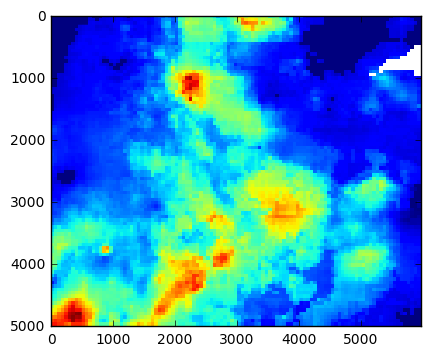

In [7]:
plt.imshow(P)
plt.show()

The Region of Interest is defined by Land-use map. A mask can be created from land-use map using *numpy.where*

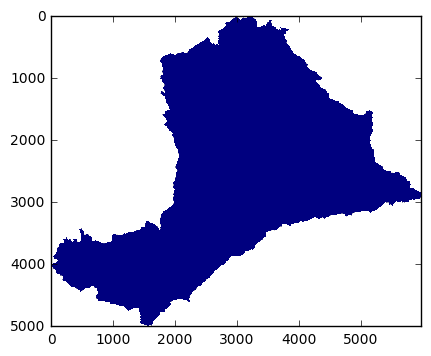

In [4]:
mask=np.where(np.isnan(LU),np.nan,1)
plt.imshow(mask)
plt.show()

By multiplying Precipitaion raster data with the *mask* array, we get only the array with data in our ROI. All the pixels outside of the ROI has nan values (nodata value).

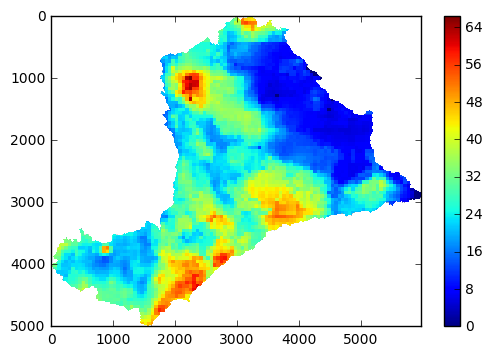

In [5]:
Basin_P=P*mask
plt.imshow(Basin_P)
plt.colorbar()
plt.show()

Thus, we can get the average Precipitation of the whole area by *numpy.nanmean* which means calculate the average excluding pixels with nan values.

In [6]:
Average_P=np.nanmean(Basin_P)
print('Average Precipitation (mm/month): {0}'.format(Average_P))

Average Precipitation (mm/month): 25.6439098263


### Exercise (+)
Get values of all monthly Precipitation maps and save the value in a Python *list* and plot average precipitation against time.

**Hint**: You can make use of the file name to get *datetime* index. Look at example below.

In [8]:
import datetime

P_fh=r"E:\Exercise\2.2\Warped\P\PCP_200901.tif"
filename=os.path.split(P_fh)[-1]    
datestr=filename.split('.')[0].split('_')[-1]
print(datestr)
dyear=int(datestr[0:4])
dmonth=int(datestr[4:6])
datetime.date(dyear,dmonth,1)

200901


datetime.date(2009, 1, 1)

In [ ]:
# Write your code here

In [9]:
LU_fh=r"E:\Exercise\Awash\LUWA\Awash2009.tif"
LU=OpenRasterAsArray(LU_fh)
mask=np.where(np.isnan(LU),np.nan,1)

dates=[]
months=[]
years=[]
P_values=[]
for P_fh in P_fhs:
    filename=os.path.split(P_fh)[-1]    
    datestr=filename.split('.')[0].split('_')[-1]
    dyear=int(datestr[0:4]) #convert string to integer number
    dmonth=int(datestr[4:6])
    dates.append(datetime.date(dyear,dmonth,1))
    months.append(dmonth)
    years.append(dyear)
    #Calculate value
    P=OpenRasterAsArray(P_fh)    
    Basin_P=P*mask
    Average_P=np.nanmean(Basin_P)
    P_values.append(Average_P)

In [ ]:
plt.plot(P_values)
plt.show()

We can decorate our graph with some extra code. For example

In [ ]:
output_dir=r'E:\Exercise\2.2\Plots'
fig = plt.figure(figsize = (10,5))
plt.clf() #clear plot
plt.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) #Grid line
ax = plt.subplot(111)
ax.plot(dates, P_values, '-k') #Plot data as line
ax.fill_between(dates, P_values, color = '#6bb8cc') #Fill line area with color
ax.set_xlabel('Time') # X axis title
ax.set_ylabel('Precipitation [mm/month]') #Y axis title
ax.set_title('Precipitation, Awash Basin') #Figure title
fig.autofmt_xdate()
plt.savefig(os.path.join(output_dir, 'Precipitation_Awash_ts.png'))
plt.show()
plt.close(fig)

## 2. Working with timeseries (pandas library)
### Example
The lists created (*dates*, *months*, *years*, *P_values*) can be combined in a DataFrame object using *pandas.DataFrame*. This structure makes cleaning, transforming, manipulating and analyzing data easier.

In [ ]:
P_df=pd.DataFrame({'date':dates,'month':months,'year':years,'value': P_values})
P_df.head

For example, we can easily sum up precipitation of the monthly values into the yearly total precipitation using *groupby* of column *year* with method *sum*.

In [ ]:
Year_total=P_df.groupby(['year']).sum()
Year_total['value']

DataFrame columns can be converted to array and plotted easily. Below is the code to plot the total yearly precipitation. Discuss the interannual variation of precipitation in Awash.

In [ ]:
fig = plt.figure(figsize = (10,5))
plt.clf() #clear plot
ax2 = plt.subplot(111)
ax2.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) #Grid line
ax2.bar(Year_total.index, Year_total['value'].values, 0.8, color = '#6bb8cc')
ax2.set_xlabel('Time [Year]')
ax2.set_xticks(Year_total.index)
ax2.set_ylabel('Precipitation [mm/year]')
ax2.set_title('Yearly Total Precipitation, Awash')
plt.savefig(os.path.join(output_dir, 'Precipitation_Awash_year.png'))
plt.show()
plt.close(fig)

### Exercise (+)
Calculate and plot the mean Precipitation of the calendar months. Discuss precipitation distribution in an average year.

**Hint**
Instead of using method *sum* in *groupby*, use *mean* 

In [ ]:
#%% Write your code here

In [ ]:
Month_avg=P_df.groupby(['month']).mean()
Month_avg['value']
fig = plt.figure(figsize = (10,5))
plt.clf() #clear plot
#subplot 1
ax1 = plt.subplot(111)
ax1.grid(b=True, which='Major', color='0.65',linestyle='--', zorder = 0) #Grid line
ax1.bar(Month_avg.index, Month_avg['value'].values, 0.8, color = '#6bb8cc')
ax1.set_xlabel('Time [month]')
monthname={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
monthslabel=monthname.values()
ax1.set_xticks(Month_avg.index)
ax1.set_xticklabels(monthslabel)
ax1.set_ylabel('Precipitation [mm/month]')
ax1.set_title('Monthly average Precipitation, Awash')
plt.savefig(os.path.join(output_dir, 'Precipitation_Awash_month.png'))
plt.show()
plt.close(fig)

We can also save our dataframe as csv file using pandas.DataFrame method *to_csv* for later use in other analysis. 

In [ ]:
Month_max=P_df.groupby(['month']).max()
Month_min=P_df.groupby(['month']).min()
Month_med=P_df.groupby(['month']).median()
Month_std=P_df.groupby(['month']).std()

Month_stat=pd.DataFrame({'month': Month_avg.index,'Mean':Month_avg['value'].values,
                        'Max':Month_max['value'].values, 'Min':Month_min['value'].values,
                        'Median':Month_med['value'].values,'Std':Month_std['value'].values})
print(Month_stat)
Month_stat.to_csv(r'E:\Exercise\2.2\P_month_stats.csv',sep=';')

## 3. Raster calculation
### Example: P - ET
First, we need to get the file handler of the rasters of the same date that have been matched projection, size and resolution. We can make use of the time format in file name as below.

In [ ]:
start_date='2009-01-01'
end_date='2009-12-31'
dates=pd.date_range(start_date,end_date,freq='M')
P_path=r'E:\Exercise\2.2\Warped\P\PCP_{:04d}{:02d}.tif'
ET_path=r'E:\Exercise\2.2\Warped\ET\AETI_{:04d}{:02d}.tif'

date=dates[0]
print(date)
P_fh=P_path.format(date.year,date.month)
ET_fh=ET_path.format(date.year,date.month)
print(P_fh)
print(ET_fh)

The difference between Precipitation and Total EvapoTranspiration (P-ET) of the pixel can indicate whether the pixel is sink or source of water. When P-ET>0, water is generated in the pixel area. When P-ET< 0, water is more depleted in the pixel area. For example, below is how we can calculate P-ET for one month (January 2009). Notice where P-ET is negative and positive.

In [ ]:
P=OpenRasterAsArray(P_fh)
ET=OpenRasterAsArray(ET_fh)
P_ET=P-ET
plt.imshow(P_ET)
plt.colorbar()
plt.show()

### Exercise (++) 
Calculate annual P - ET of a chosen year in Awash Basin. Discuss the source (P-ET > 0) and sink (P-ET < 0) of water and compare your year result with others.

**Hint**: You can calculate total annual map of P and ET from monthly maps then substract annual ET from annual P map or calculate difference each month then sum up. 
Questions:
- Would the two method give same results? Why?
- Which method is faster? Why?

In [ ]:
#%% Write your code here

## 4. Land-use analysis
### Example:
Get value per a land-use class (Water bodies).

In [ ]:
LU_fh=r"E:\Exercise\Awash\LUWA\Awash2009.tif"
in_fh=r"E:\Exercise\2.2\Warped\ET\AETI_200901.tif"

LU=OpenRasterAsArray(LU_fh)
LU_values=np.unique(LU[~np.isnan(LU)])
LU_codes=list(LU_values)
print(LU_codes)

In [ ]:
code=24 #Natural lake

mask=np.where(LU==code,0,1)
var=OpenRasterAsArray(in_fh)

import numpy.ma as ma
masked_map=ma.masked_array(var,mask)
plt.imshow(masked_map)
plt.colorbar()
plt.show()

In [ ]:
average=np.nanmean(masked_map)
print('Landuse class {0} Average: {1}'.format(code,average))

### Exercise (++)
Calculate a table of annual average ET, E,T, I and P-ET of all land-use class. 
Discuss which land-use class is sink and which is source. 
Compare Evaporation in the main classes: Forest, Shrubland, Grassland, Water bodies, Bare land, Rainfed crops, Irrigated crops.

**Hints**: You can use a for-loop over all land-use classes in the land-use map.

In [ ]:
#%% Write your code here

In [ ]:
averages=[]
for code in LU_codes:
    mask=np.where(LU==code,0,1)
    masked_map=ma.masked_array(var,mask)
    averages.append(np.nanmean(masked_map))
LU_avg=pd.DataFrame({'LU code':LU_codes,'Average Value': averages})
LU_avg